Repeating games: 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.22s/it]


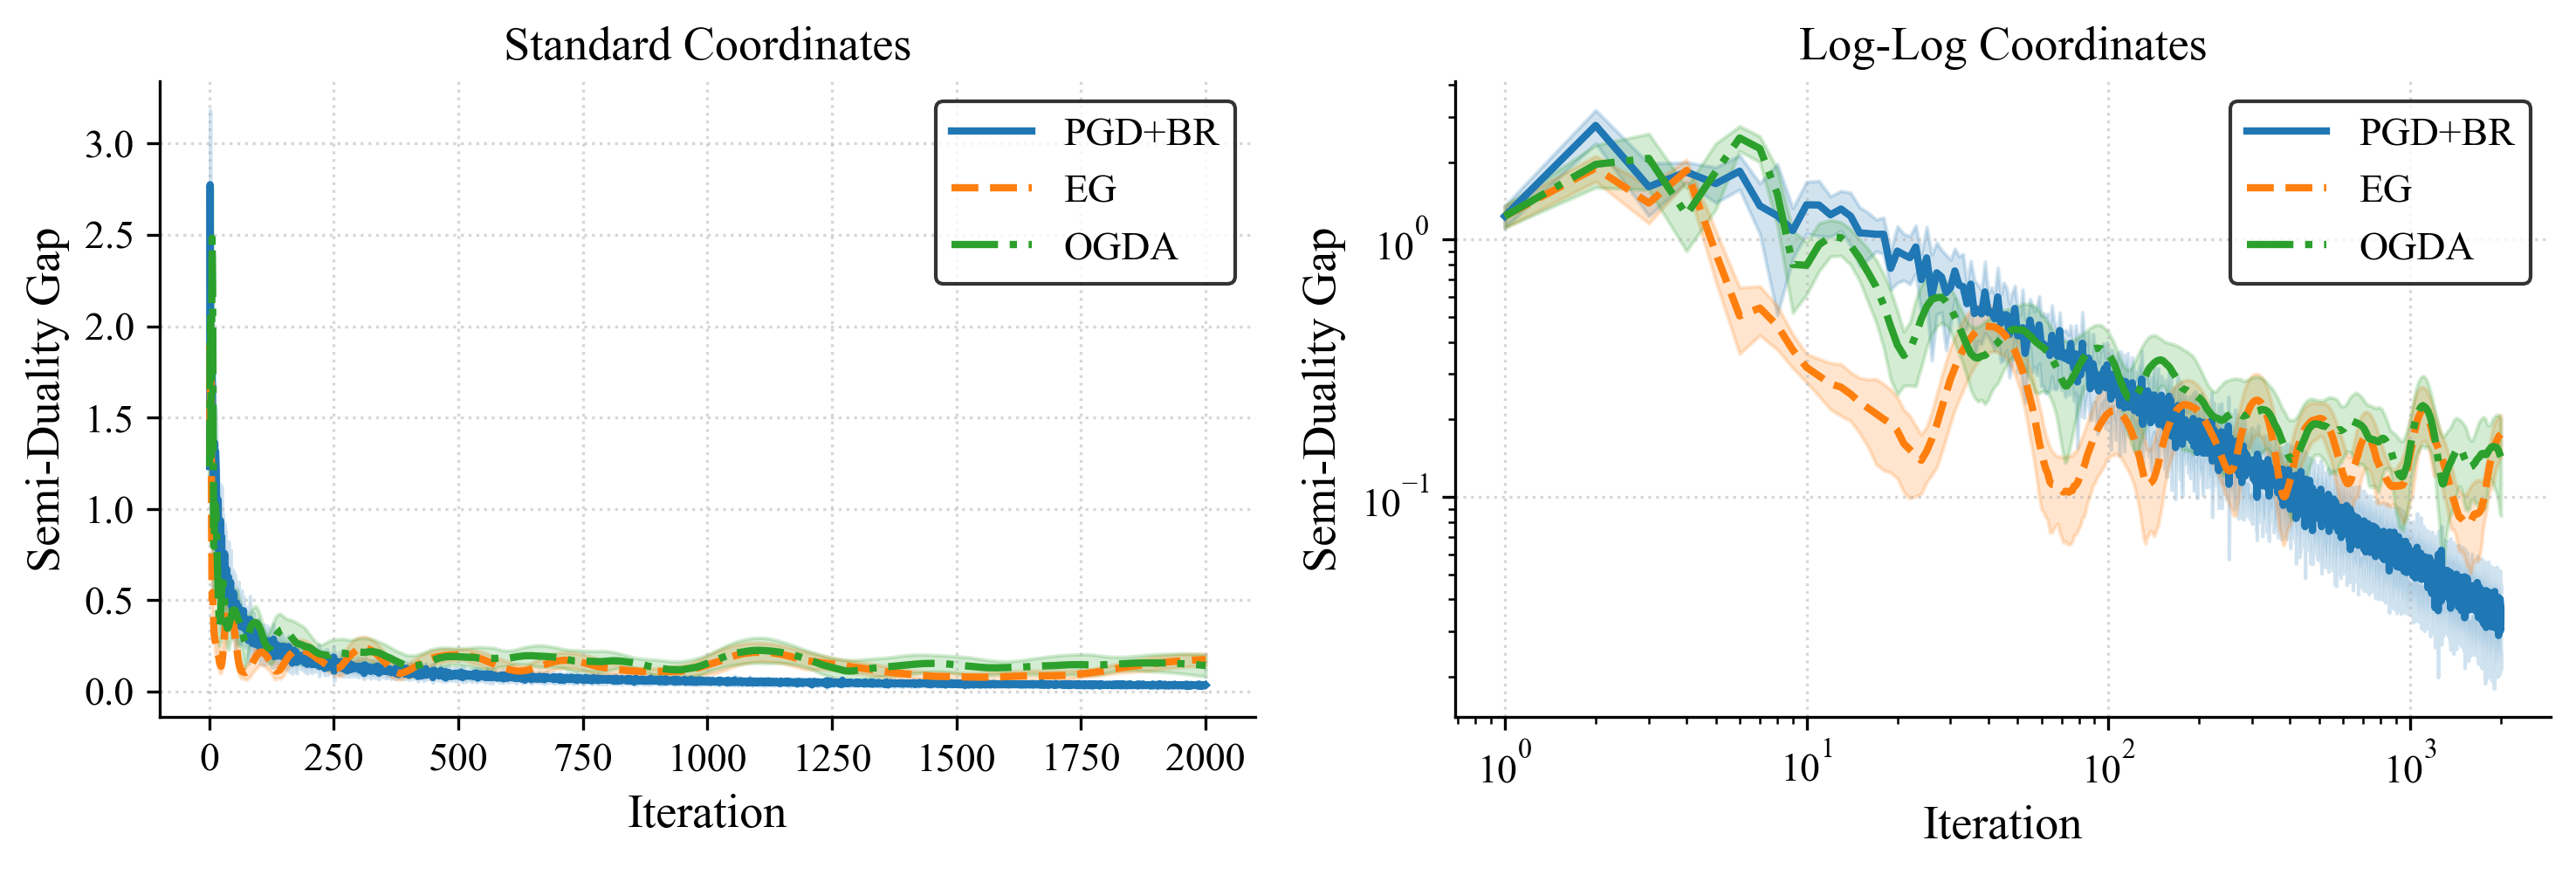

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm import trange
from matplotlib.ticker import FuncFormatter


def project_to_simplex(y):
    n = len(y)
    u = np.sort(y)[::-1]
    cumsum_u = np.cumsum(u)
    k = np.max(np.where(u > (cumsum_u - 1) / (np.arange(1, n + 1)))[0]) + 1
    theta = (cumsum_u[k - 1] - 1) / k
    return np.maximum(y - theta, 0)

def compute_value_of_saddle_point_prob(payoff_matrix, time_horizon=10000):
    n, m = payoff_matrix.shape
    strategy_x_t = np.ones(n) / n
    strategy_y_t = np.ones(m) / m
    time_average_strategy_x = strategy_x_t.copy()
    time_average_strategy_y = strategy_y_t.copy()

    eta_x = np.sqrt(8 * np.log(n) / time_horizon)
    eta_y = np.sqrt(8 * np.log(m) / time_horizon)

    for ite in range(time_horizon):
        tmp_x = strategy_x_t.copy()
        tmp_y = strategy_y_t.copy()
        strategy_x_t = strategy_x_t * np.exp(-eta_x * payoff_matrix @ tmp_y)
        strategy_x_t /= np.sum(strategy_x_t)
        strategy_y_t = strategy_y_t * np.exp(eta_y * payoff_matrix.T @ tmp_x)
        strategy_y_t /= np.sum(strategy_y_t)
        time_average_strategy_x = (1/(ite+2)) * strategy_x_t + ((ite+1)/(ite+2)) * time_average_strategy_x
        time_average_strategy_y = (1/(ite+2)) * strategy_y_t + ((ite+1)/(ite+2)) * time_average_strategy_y

    return time_average_strategy_x.T @ payoff_matrix @ time_average_strategy_y

def run_single_game(A, T, eps, v_ast):
    n, m = A.shape
    xt_PBR = np.ones(n) / n
    xt_EG = np.ones(n) / n
    yt_EG = np.ones(m) / m

    xt_1_OGDA = np.zeros(n)
    xt_1_OGDA[0] = 1
    xt_OGDA = np.ones(n) / n
    yt_1_OGDA = np.zeros(m)
    yt_1_OGDA[0] = 1
    yt_OGDA = np.ones(m) / m

    indx_mat = np.eye(m)

    V_PBR = []
    V_EG = []
    V_OGDA = []

    for t in range(T):
        At = A + np.random.uniform(-1 / ((t+1)**eps), 1 / ((t+1)**eps), size=(n, m))
        lambda_t = 0.1 / ((t+1)**0.7)

        # PGD + BR
        yt = indx_mat[:, np.argmax(xt_PBR.T @ At)]
        V_PBR.append(np.max(xt_PBR.T @ At) - v_ast)
        xt_PBR = project_to_simplex(xt_PBR - lambda_t * At @ yt)

        # Extra Gradient
        V_EG.append(np.max(xt_EG.T @ At) - v_ast)
        x_mid = project_to_simplex(xt_EG - lambda_t * At @ yt_EG)
        y_mid = project_to_simplex(yt_EG + lambda_t * At.T @ xt_EG)
        xt_EG = project_to_simplex(xt_EG - lambda_t * At @ y_mid)
        yt_EG = project_to_simplex(yt_EG + lambda_t * At.T @ x_mid)

        # OGDA
        V_OGDA.append(np.max(xt_OGDA.T @ At) - v_ast)
        x_mid_ogda = project_to_simplex(xt_OGDA - lambda_t * At @ yt_1_OGDA)
        y_mid_ogda = project_to_simplex(yt_OGDA + lambda_t * At.T @ xt_1_OGDA)
        xt_OGDA, xt_1_OGDA = project_to_simplex(xt_OGDA - lambda_t * At @ y_mid_ogda), xt_OGDA
        yt_OGDA, yt_1_OGDA = project_to_simplex(yt_OGDA + lambda_t * At.T @ x_mid_ogda), yt_OGDA

    return np.array(V_PBR), np.array(V_EG), np.array(V_OGDA)


def plot_mean_std(iters, data_dict, title_suffix="Semi-Duality Gap"):
    plt.rcParams.update({
        "font.family": "Times New Roman",
        "font.size": 12,
        "axes.labelsize": 13,
        "axes.titlesize": 13,
        "legend.fontsize": 11,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "lines.linewidth": 2,
        "legend.frameon": True,
        "legend.edgecolor": 'black',
        "figure.dpi": 300
    })

    fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))

    colors = {'PGD+BR': 'tab:blue', 'EG': 'tab:orange', 'OGDA': 'tab:green'}
    linestyles = {'PGD+BR': '-', 'EG': '--', 'OGDA': '-.'}

    for ax, log_scale in zip(axs, [False, True]):
        for name, data in data_dict.items():
            mean_vals = np.mean(data, axis=0)
            std_vals = np.std(data, axis=0)
            ax.plot(iters, mean_vals, label=name, color=colors[name], linestyle=linestyles[name])
            ax.fill_between(iters, mean_vals - std_vals, mean_vals + std_vals,
                            color=colors[name], alpha=0.2)

        ax.set_xlabel("Iteration")
        ax.set_ylabel(title_suffix)
        ax.set_title("Log-Log Coordinates" if log_scale else "Standard Coordinates")
        if log_scale:
            ax.set_xscale("log")
            ax.set_yscale("log")
        ax.grid(True, linestyle=':', alpha=0.5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.legend()

    plt.tight_layout()
    plt.savefig("comp_with_EG_OGDA.pdf", bbox_inches="tight")
    plt.show()


# ========== multiple rounds of experiments ==========
n, m = 20, 30
T = 2000
eps = 1
n_runs = 20
np.random.seed(0)
A = np.random.uniform(-5, 5, size=(n, m))
v_ast = compute_value_of_saddle_point_prob(A, 10000)

# shape = (n_runs, T)
V_PBR_all = []
V_EG_all = []
V_OGDA_all = []

for _ in tqdm(range(n_runs), desc="Repeating games"):
    v_pbr, v_eg, v_ogda = run_single_game(A, T, eps, v_ast)
    V_PBR_all.append(v_pbr)
    V_EG_all.append(v_eg)
    V_OGDA_all.append(v_ogda)

V_PBR_all = np.array(V_PBR_all)
V_EG_all = np.array(V_EG_all)
V_OGDA_all = np.array(V_OGDA_all)
iters = np.arange(1, T + 1)

# 设置统一风格
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 12,
    "axes.labelsize": 13,
    "axes.titlesize": 13,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "lines.linewidth": 2,
    "legend.frameon": True,
    "legend.edgecolor": 'black',
    "figure.dpi": 300
})



iters = np.arange(1, T + 1)
data_dict = {
    "PGD+BR": V_PBR_all,
    "EG": V_EG_all,
    "OGDA": V_OGDA_all
}
plot_mean_std(iters, data_dict)